Loading model...
Model loaded successfully.
Labels  tensor([10, 10, 10, 10, 10, 10, 10, 10], device='cuda:1')
Generating samples...
Generated images saved to ./SampledImgs/SampledInferenceImgs.png


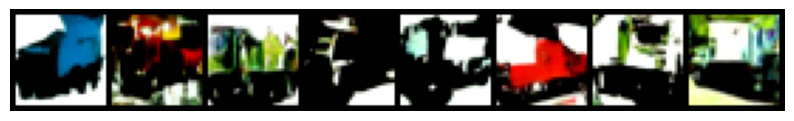

In [80]:
import os
import torch
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from DiffusionFreeGuidence.DiffusionCondition import GaussianDiffusionSampler
from DiffusionFreeGuidence.ModelCondition import UNet

def display_images(images, nrow=8):
    """
    Display a grid of images using Matplotlib
    :param images: Tensor of shape (batch_size, 3, img_size, img_size)
    :param nrow: Number of images per row
    """
    # Use make_grid to create a grid of images
    grid_img = make_grid(images, nrow=nrow, normalize=True).cpu()
    
    # Convert the grid to numpy format and transpose it for matplotlib (C, H, W) -> (H, W, C)
    np_grid = grid_img.numpy().transpose(1, 2, 0)

    # Display the grid using Matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(np_grid)
    plt.axis('off')
    plt.show()


def inference(modelConfig):
    # Set device
    device = torch.device(modelConfig["device"])

    # Load the trained model
    print("Loading model...")
    model = UNet(
        T=modelConfig["T"], 
        num_labels=10, 
        ch=modelConfig["channel"], 
        ch_mult=modelConfig["channel_mult"], 
        num_res_blocks=modelConfig["num_res_blocks"], 
        dropout=modelConfig["dropout"]
    ).to(device)

    ckpt_path = os.path.join(modelConfig["save_dir"], modelConfig["test_load_weight"])
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"Checkpoint not found at {ckpt_path}")

    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt)
    print("Model loaded successfully.")

    model.eval()

    # Initialize the sampler
    sampler = GaussianDiffusionSampler(
        model, modelConfig["beta_1"], modelConfig["beta_T"], modelConfig["T"], w=modelConfig["w"]
    ).to(device)

    # Generate noisy image (sampling from a standard normal distribution)
    noisy_image = torch.randn(
        size=[modelConfig["batch_size"], 3, modelConfig["img_size"], modelConfig["img_size"]], device=device
    )
    
    # Optionally save noisy images
    save_noisy = torch.clamp(noisy_image * 0.5 + 0.5, 0, 1)
    save_image(save_noisy, os.path.join(modelConfig["sampled_dir"], modelConfig["sampledNoisyImgName"]), nrow=modelConfig["nrow"])

    # Generate labels (e.g., all ones for a specific class or randomly sampled)
    labels = torch.randint(10, 11, (modelConfig["batch_size"],), device=device)
    print('Labels ', labels)

    # Generate samples using the sampler
    print("Generating samples...")
    with torch.no_grad():
        sampled_images = sampler(noisy_image, labels)
        sampled_images = (sampled_images * 0.5 + 0.5)  # Rescale to [0, 1]

    # Save generated samples
    save_image(sampled_images, os.path.join(modelConfig["sampled_dir"], modelConfig["sampledImgName"]), nrow=modelConfig["nrow"])
    print(f"Generated images saved to {os.path.join(modelConfig['sampled_dir'], modelConfig['sampledImgName'])}")

    # Display generated samples using Matplotlib
    display_images(sampled_images, nrow=modelConfig["nrow"])

if __name__ == '__main__':
    # Example configuration (you can modify this as needed)
    modelConfig = {
        "batch_size": 8,                 # Batch size for inference
        "T": 500,                        # Number of time steps in diffusion process
        "channel": 128,                  # Channel size of the UNet
        "channel_mult": [1, 2, 2, 2],    # Channel multiplier for UNet
        "num_res_blocks": 2,             # Number of residual blocks
        "dropout": 0.15,                 # Dropout rate
        "beta_1": 1e-4,                  # Beta 1 for diffusion process
        "beta_T": 0.028,                 # Beta T for diffusion process
        "img_size": 32,                  # Image size
        "w": 1.8,                        # Weight for guidance
        "device": "cuda:1",              # Device for computation
        "save_dir": "./CheckpointsCondition/", # Directory to load the model checkpoint
        "test_load_weight": "ckpt_cosineSchedule_69_.pt", # Model weight to load
        "sampled_dir": "./SampledImgs/", # Directory to save sampled images
        "sampledNoisyImgName": "NoisyInferenceImgs.png", # Filename for noisy images
        "sampledImgName": "SampledInferenceImgs.png",    # Filename for sampled images
        "nrow": 8                         # Number of images per row for saving
    }

    inference(modelConfig)